<a href="https://colab.research.google.com/github/San-lab-ship/prediccion_fuga_clientes_betabank/blob/main/BetaBank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# cargue de datos

import pandas as pd
from google.colab import files

# Pide al usuario que suba un archivo
uploaded = files.upload()

file_name = next(iter(uploaded))
print(f"Archivo '{file_name}' subido exitosamente.")

try:
    df = pd.read_csv(file_name)
    print("\n¡Datos cargados exitosamente!")
    print(f"Las primeras 5 filas de tu dataset son:\n{df.head()}")
    print(f"\nLa forma de tu dataset (filas, columnas) es: {df.shape}")
except Exception as e:
    print(f"Ocurrió un error al cargar el archivo con pandas: {e}")

Saving users_behavior.csv to users_behavior.csv
Archivo 'users_behavior.csv' subido exitosamente.

¡Datos cargados exitosamente!
Las primeras 5 filas de tu dataset son:
   calls  minutes  messages   mb_used  is_ultra
0   40.0   311.90      83.0  19915.42         0
1   85.0   516.75      56.0  22696.96         0
2   77.0   467.66      86.0  21060.45         0
3  106.0   745.53      81.0   8437.39         1
4   66.0   418.74       1.0  14502.75         0

La forma de tu dataset (filas, columnas) es: (3214, 5)


--- 0. Carga del Archivo en Google Colab ---


Saving users_behavior.csv to users_behavior (4).csv
Archivo 'users_behavior (4).csv' subido exitosamente.
¡Datos cargados exitosamente en DataFrame 'df'!
Columnas en el DataFrame: ['calls', 'minutes', 'messages', 'mb_used', 'is_ultra']

--- 1. Preprocesamiento de Datos ---
Ninguna de las columnas a eliminar predefinidas fue encontrada o necesaria.
No se encontraron columnas categóricas para One-Hot Encoding.
Datos preprocesados exitosamente. X e Y creados.
Dimensiones de X después del preprocesamiento: (3214, 4)
Dimensiones de y: (3214,)
Verificación de NaNs e Infinitos en X: 0 NaNs, 0 Infinitos

--- 2. División de Datos ---
Dimensiones del conjunto de entrenamiento: X=(1928, 4), y=(1928,)
Dimensiones del conjunto de validación: X=(643, 4), y=(643,)
Dimensiones del conjunto de prueba: X=(643, 4), y=(643,)

--- 3. Entrenamiento y Validación de Modelos ---
Evaluando modelos con class_weight='balanced'...
- Logistic Regression (class_weight='balanced'): F1=0.5289, AUC-ROC=0.6781
- Decisio

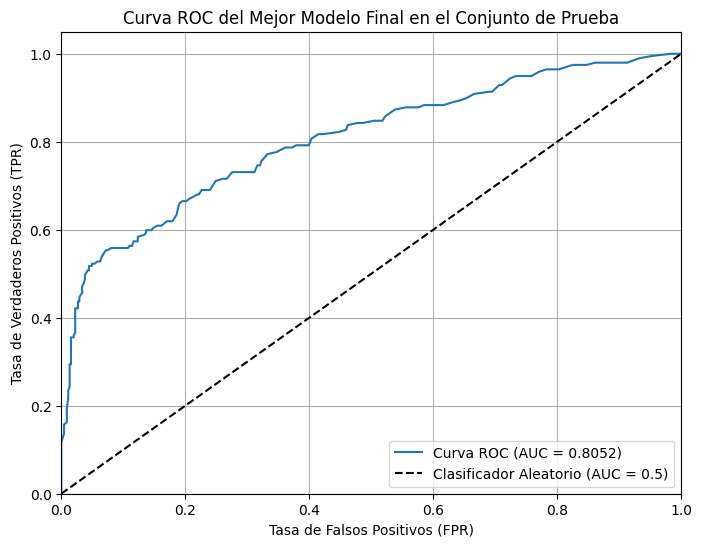

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, confusion_matrix
from google.colab import files

# --- 0. Carga del Archivo en Google Colab ---
print("--- 0. Carga del Archivo en Google Colab ---")
try:
    # Esto abrirá una ventana para que selecciones tu archivo 'users_behavior.csv'.
    uploaded = files.upload()
    file_name = next(iter(uploaded)) # Obtiene el nombre del archivo subido
    print(f"Archivo '{file_name}' subido exitosamente.")

    # Cargar el conjunto de datos en el DataFrame 'df'
    df = pd.read_csv(file_name)
    print("¡Datos cargados exitosamente en DataFrame 'df'!")
    print(f"Columnas en el DataFrame: {df.columns.tolist()}") # Verifica las columnas cargadas

except FileNotFoundError:
    print("Error: El archivo no se encontró. Asegúrate de seleccionarlo al ejecutar files.upload().")
    exit()
except Exception as e:
    print(f"Ocurrió un error al cargar el archivo: {e}")
    exit()

# --- 1. Preprocesamiento de Datos ---
print("\n--- 1. Preprocesamiento de Datos ---")
try:
    # Columnas a eliminar que pueden ser identificadores o no relevantes.
    # Con las nuevas columnas ['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'],
    # no hay columnas obvias para eliminar como 'userid', 'RowNumber', etc.
    # Si sabes de alguna columna que no deba usarse como feature, añádela aquí.
    columns_to_drop_if_exist = [] # Por ahora, ninguna columna para eliminar explícitamente
    columns_actually_dropped = []

    for col in columns_to_drop_if_exist:
        if col in df.columns:
            df = df.drop(col, axis=1)
            columns_actually_dropped.append(col)
    if columns_actually_dropped:
        print(f"Columnas eliminadas (si existían): {columns_actually_dropped}")
    else:
        print("Ninguna de las columnas a eliminar predefinidas fue encontrada o necesaria.")


    # --- ¡CORRECCIÓN IMPORTANTE AQUÍ: Actualizar el nombre de la columna objetivo! ---
    # Basado en tu última salida, la columna objetivo más probable es 'is_ultra'.
    # Si tu objetivo es diferente, CAMBIA 'is_ultra' al nombre correcto de la columna.
    target_column_name = 'is_ultra' # <--- ¡CONFIRMA ESTE NOMBRE EN TU DATASET!

    if target_column_name not in df.columns:
        print(f"Error: La columna objetivo '{target_column_name}' no se encontró en el DataFrame.")
        print("Por favor, verifica la lista de columnas para identificar el nombre correcto de la variable objetivo.")
        exit() # Detiene la ejecución si la columna objetivo no se encuentra

    # Identificar columnas numéricas y categóricas *después* de eliminar las no relevantes
    # Con tus nuevas columnas, parece que todas son numéricas.
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    if target_column_name in numerical_cols:
        numerical_cols.remove(target_column_name) # Asegura que la columna objetivo no se trate como feature para NaN/Inf

    categorical_cols = df.select_dtypes(include='object').columns.tolist() # Busca columnas tipo 'object' (strings)

    # Manejar valores NaN en columnas numéricas (usamos la mediana)
    for col in numerical_cols:
        if df[col].isnull().any():
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"NaNs en columna numérica '{col}' rellenados con la mediana: {median_val}")

    # Manejar valores infinitos si los hubiera
    for col in numerical_cols:
        if np.isinf(df[col]).any():
            median_val = df[col].replace([np.inf, -np.inf], np.nan).median()
            df[col] = df[col].replace([np.inf, -np.inf], median_val)
            print(f"Infinitos en columna numérica '{col}' rellenados con la mediana: {median_val}")

    # Aplicar One-Hot Encoding a columnas categóricas
    if categorical_cols:
        print(f"Aplicando One-Hot Encoding a columnas categóricas: {categorical_cols}")
        df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    else:
        print("No se encontraron columnas categóricas para One-Hot Encoding.") # Esto es lo esperado con tus columnas actuales

    # Separar características (X) y variable objetivo (y)
    X = df.drop(target_column_name, axis=1)
    y = df[target_column_name]

    print("Datos preprocesados exitosamente. X e Y creados.")
    print(f"Dimensiones de X después del preprocesamiento: {X.shape}")
    print(f"Dimensiones de y: {y.shape}")

    # Verificar si quedan NaNs o infinitos en X
    if X.isnull().sum().sum() == 0 and np.isinf(X).sum().sum() == 0:
        print(f"Verificación de NaNs e Infinitos en X: {X.isnull().sum().sum()} NaNs, {np.isinf(X).sum().sum()} Infinitos")
    else:
        print("¡Advertencia: Todavía hay NaNs o Infinitos en X después del preprocesamiento!")


except Exception as e:
    print(f"Ocurrió un error inesperado al preprocesar el DataFrame: {e}")
    exit()

# --- 2. División de Datos (Entrenamiento, Validación, Prueba) ---
print("\n--- 2. División de Datos ---")
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=12345, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=12345, stratify=y_train_val
)
print(f"Dimensiones del conjunto de entrenamiento: X={X_train.shape}, y={y_train.shape}")
print(f"Dimensiones del conjunto de validación: X={X_val.shape}, y={y_val.shape}")
print(f"Dimensiones del conjunto de prueba: X={X_test.shape}, y={y_test.shape}")


# --- 3. Entrenamiento y Validación de Modelos con Manejo de Desequilibrio ---
print("\n--- 3. Entrenamiento y Validación de Modelos ---")

def find_best_threshold(probabilities, true_labels):
    best_f1 = 0
    best_threshold = 0.5
    thresholds = np.arange(0.05, 1.0, 0.05)
    if len(thresholds) == 0:
        thresholds = [0.5]

    for threshold in thresholds:
        y_pred = (probabilities > threshold).astype(int)
        if len(np.unique(y_pred)) < 2 or len(np.unique(true_labels)) < 2:
            continue
        f1 = f1_score(true_labels, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_f1, best_threshold

results = []

print("Evaluando modelos con class_weight='balanced'...")
models_balanced = {
    "Logistic Regression": LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=12345, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=12345, class_weight='balanced')
}

for name, model in models_balanced.items():
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    y_proba_val = model.predict_proba(X_val)[:, 1]
    f1 = f1_score(y_val, y_pred_val)
    auc_roc = roc_auc_score(y_val, y_proba_val)
    results.append({
        "Model": name,
        "Technique": "class_weight='balanced'",
        "F1_Validation": f1,
        "AUC_ROC_Validation": auc_roc,
        "Best_Threshold": 0.5,
        "Model_Object": model
    })
    print(f"- {name} (class_weight='balanced'): F1={f1:.4f}, AUC-ROC={auc_roc:.4f}")

print("\nEvaluando modelos con ajuste de umbral...")
dt_depths = range(1, 11)
rf_estimators = [50, 100, 150, 200]

best_dt_f1 = -1
best_dt_threshold_model = None
best_dt_threshold_depth = None
best_dt_threshold_value = 0.5

for depth in dt_depths:
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dt.fit(X_train, y_train)
    y_proba_val = model_dt.predict_proba(X_val)[:, 1]
    f1_current, threshold_current = find_best_threshold(y_proba_val, y_val)
    if f1_current > best_dt_f1:
        best_dt_f1 = f1_current
        best_dt_threshold_model = model_dt
        best_dt_threshold_depth = depth
        best_dt_threshold_value = threshold_current

if best_dt_threshold_model:
    y_proba_val = best_dt_threshold_model.predict_proba(X_val)[:, 1]
    auc_roc = roc_auc_score(y_val, y_proba_val)
    results.append({
        "Model": f"Decision Tree (Depth={best_dt_threshold_depth})",
        "Technique": "Threshold Adjustment",
        "F1_Validation": best_dt_f1,
        "AUC_ROC_Validation": auc_roc,
        "Best_Threshold": best_dt_threshold_value,
        "Model_Object": best_dt_threshold_model
    })
    print(f"- Decision Tree (Threshold Adjusted, Depth={best_dt_threshold_depth}): F1={best_dt_f1:.4f}, AUC-ROC={auc_roc:.4f}, Best Threshold={best_dt_threshold_value:.2f}")

best_rf_f1 = -1
best_rf_threshold_model = None
best_rf_threshold_estimators = None
best_rf_threshold_value = 0.5

for n_est in rf_estimators:
    model_rf = RandomForestClassifier(random_state=12345, n_estimators=n_est)
    model_rf.fit(X_train, y_train)
    y_proba_val = model_rf.predict_proba(X_val)[:, 1]
    f1_current, threshold_current = find_best_threshold(y_proba_val, y_val)
    if f1_current > best_rf_f1:
        best_rf_f1 = f1_current
        best_rf_threshold_model = model_rf
        best_rf_threshold_estimators = n_est
        best_rf_threshold_value = threshold_current

if best_rf_threshold_model:
    y_proba_val = best_rf_threshold_model.predict_proba(X_val)[:, 1]
    auc_roc = roc_auc_score(y_val, y_proba_val)
    results.append({
        "Model": f"Random Forest (Estimators={best_rf_threshold_estimators})",
        "Technique": "Threshold Adjustment",
        "F1_Validation": best_rf_f1,
        "AUC_ROC_Validation": auc_roc,
        "Best_Threshold": best_rf_threshold_value,
        "Model_Object": best_rf_threshold_model
    })
    print(f"- Random Forest (Threshold Adjusted, Estimators={best_rf_threshold_estimators}): F1={best_rf_f1:.4f}, AUC-ROC={auc_roc:.4f}, Best Threshold={best_rf_threshold_value:.2f}")

best_model_overall = None
highest_f1_val = -1
best_model_info = {}

for res in results:
    if res['F1_Validation'] > highest_f1_val:
        highest_f1_val = res['F1_Validation']
        best_model_overall = res['Model_Object']
        best_model_info = res

print(f"\n--- Mejor Modelo Seleccionado en Validación ---")
print(f"Modelo: {best_model_info['Model']}")
print(f"Técnica: {best_model_info['Technique']}")
print(f"F1-Score en Validación: {best_model_info['F1_Validation']:.4f}")
print(f"AUC-ROC en Validación: {best_model_info['AUC_ROC_Validation']:.4f}")
print(f"Umbral Óptimo: {best_model_info['Best_Threshold']:.2f}")


# --- 4. Prueba Final del Mejor Modelo ---
print("\n--- 4. Prueba Final del Mejor Modelo ---")
if best_model_overall:
    y_proba_final = best_model_overall.predict_proba(X_test)[:, 1]
    best_threshold_final = best_model_info['Best_Threshold']
    y_pred_final = (y_proba_final > best_threshold_final).astype(int)

    f1_final = f1_score(y_test, y_pred_final)
    auc_roc_final = roc_auc_score(y_test, y_proba_final)

    print(f"\n**Métricas del Mejor Modelo Final ({best_model_info['Model']}) en el Conjunto de Prueba:**")
    print(f"**F1-Score:** {f1_final:.4f}")
    print(f"**AUC-ROC:** {auc_roc_final:.4f}")

    print("\n--- Informe de Clasificación Detallado ---")
    print(classification_report(y_test, y_pred_final))

    print("\n--- Matriz de Confusión ---")
    print(confusion_matrix(y_test, y_pred_final))

    fpr, tpr, thresholds = roc_curve(y_test, y_proba_final)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc_roc_final:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC del Mejor Modelo Final en el Conjunto de Prueba')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

else:
    print("No se pudo seleccionar un modelo para la prueba final.")